In [4]:
# recall df
%store -r w_df
%store -r w_test
%store -r w_train
%store -r w_train_seas_diff

PAKAGES

In [2]:
import numpy as np
import pandas as pd
import math
import statistics
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns


# for pattern identification 
from scipy.fft import fft, ifft, fftshift, ifftshift
from scipy import signal

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

## TRAIN/TEST

First we want to split the data in train and test take in consideration only the variable that we want to predict 
(in the past train/test division we define the period of time that we have in the requirment, but we have all the variables)

In [3]:
feature='T (degC)'

# TRAIN/TEST division 

train_t=w_train[feature]
test_t=w_test[feature]

## Simple exponential smoothing

The simplest of the exponentially smoothing methods is called simple exponential smoothing (SES), also referred to as single exponential smoothing. **This method is suitable for forecasting data with no clear trend or seasonal pattern.**
When using the naïve method, all forecasts for the future are equal to the last observed value.

Forecasts are calculated using weighted averages, where the weights decrease exponentially as observations are distant in the past (i.e, the smallest weights are associated with the oldest observations).
Exponential smoothing methods are generally expressed in the component form, with one forecast equation and one smoothing equation per component.


--> so in our case we have a strong seasonal component so in order to obtain better result could be better to use **DESEASONAL VALUE**

### 1_s) SAS - SEASONAL TRAIN 

,Param Name,Values
0,smoothing_level,0.716936
1,initial_level,-5.404262


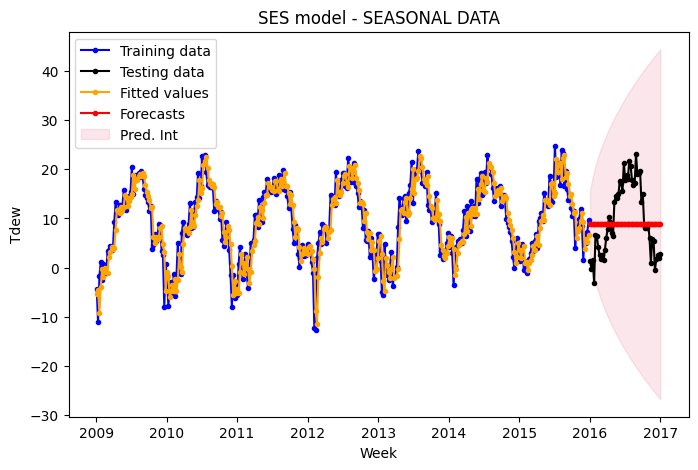

In [29]:
# we start appling it with the seasonal data
model_sta_SES = ETSModel(train_t, error = 'add').fit()

# parameters
par_table_sta = {'Param Name': model_sta_SES.param_names, 'Values': model_sta_SES.params}
par_table_sta = pd.DataFrame(par_table_sta)
display(par_table_sta)

# prediction
pred_model_sta_SES=model_sta_SES.get_prediction(start=test_t.index[0],end=test_t.index[-1])
# summary
summary_sta_SESmodel_df=pred_model_sta_SES.summary_frame()
#forecast
forecast_sta=summary_sta_SESmodel_df['mean']

# PLOT
plt.figure(figsize=(8,5))
plt.plot(train_t, color='blue',marker = '.',label='Training data')
plt.plot(test_t, color='black', marker = '.',label='Testing data')
plt.plot(model_sta_SES.fittedvalues,color='orange', marker = '.', label='Fitted values')
plt.plot(forecast_sta, color='red', marker = '.', label='Forecasts')
plt.fill_between(summary_sta_SESmodel_df.index, summary_sta_SESmodel_df['pi_lower'], summary_sta_SESmodel_df['pi_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Week')
plt.ylabel('Tdew')
plt.title('SES model - SEASONAL DATA')
plt.legend()
plt.show()

### DESEASONAL TRAIN 

In [5]:
# Deseasonal one
w_train_seas_diff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2009-01-04 to 2015-12-27
Freq: W-SUN
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p (mbar)         313 non-null    float64
 1   T (degC)         313 non-null    float64
 2   Tpot (K)         313 non-null    float64
 3   Tdew (degC)      313 non-null    float64
 4   rh (%)           313 non-null    float64
 5   VPmax (mbar)     313 non-null    float64
 6   VPact (mbar)     313 non-null    float64
 7   VPdef (mbar)     313 non-null    float64
 8   sh (g/kg)        313 non-null    float64
 9   H2OC (mmol/mol)  313 non-null    float64
 10  rho (g/m**3)     313 non-null    float64
 11  wv (m/s)         313 non-null    float64
 12  max. wv (m/s)    313 non-null    float64
 13  wd (deg)         313 non-null    float64
dtypes: float64(14)
memory usage: 42.8 KB


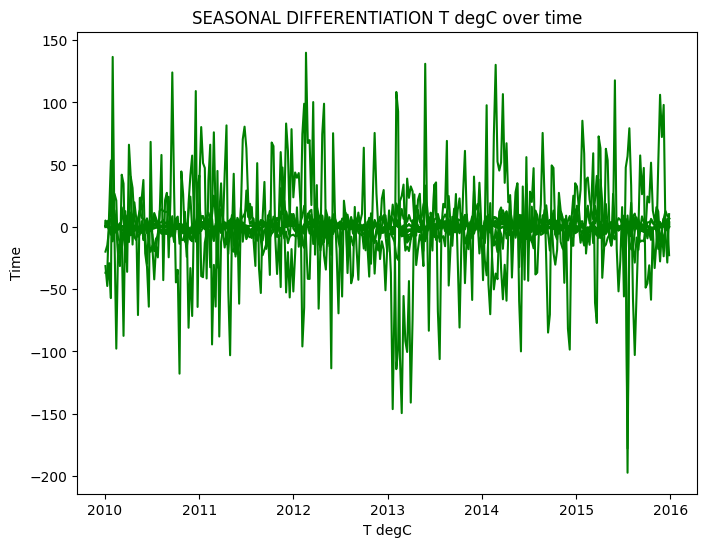

In [6]:
# first i want to remove null values
w_train_seas_diff.dropna(inplace=True)

# PLOT
plt.figure(figsize=(8,6))
plt.plot(w_train_seas_diff,color='Green')
plt.xlabel('T degC')
plt.ylabel('Time')
plt.title('SEASONAL DIFFERENTIATION T degC over time')
plt.show()

In [22]:
# TRAIN/TEST --> DESEASONAL DATA
 
feature='T (degC)'

# TRAIN/TEST division 
des_train_t=w_train_seas_diff[w_train_seas_diff.index < '2016-01-01'][feature]


### 1_d) SES - with deseasonal train 


,Param Name,Values
0,smoothing_level,0.114677
1,initial_level,-0.958494


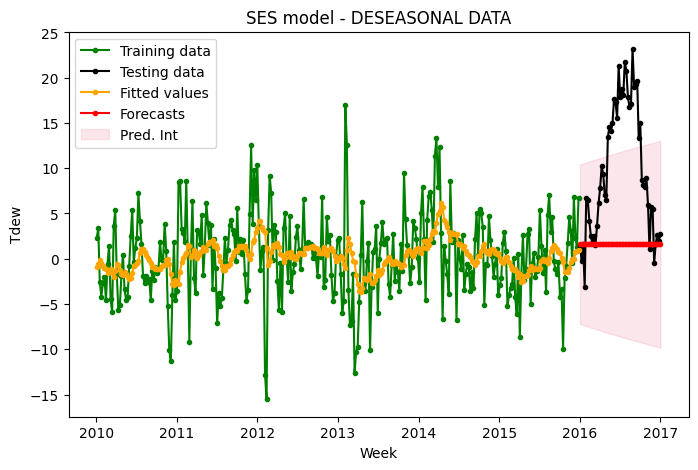

In [30]:
model_des_SES = ETSModel(des_train_t, error = 'add').fit()

# parameters
par_table = {'Param Name': model_des_SES.param_names, 'Values': model_des_SES.params}
par_table = pd.DataFrame(par_table)
display(par_table)

# prediction
pred_model_des_SES=model_des_SES.get_prediction(start=test_t.index[0],end=test_t.index[-1])
# summary
summary_SESmodel_df=pred_model_des_SES.summary_frame()
#forecast
forecast=summary_SESmodel_df['mean']

# PLOT
plt.figure(figsize=(8,5))
plt.plot(des_train_t, color='green',marker = '.',label='Training data')
plt.plot(test_t, color='black', marker = '.',label='Testing data')
plt.plot(model_des_SES.fittedvalues,color='orange', marker = '.', label='Fitted values')
plt.plot(forecast, color='red', marker = '.', label='Forecasts')
plt.fill_between(summary_SESmodel_df.index, summary_SESmodel_df['pi_lower'], summary_SESmodel_df['pi_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Week')
plt.ylabel('Tdew')
plt.title('SES model - DESEASONAL DATA')
plt.legend()
plt.show()

In [26]:
model_des_SES.aic

np.float64(1834.3555502337595)

In [27]:
model_sta_SES.aic

np.float64(1945.4389495917223)

#### CONCLUSIONI

seeams that the models with the deseasonal data are better than the model with the seasonal one.

## Holt’s linear trend method (Double Exponential Smoothing)

The method supports trends that change in different ways: *additive and multiplicative*, depending on whether the trend is linear or exponential, respectively. However, multiplicative trend methods tend to (often) produce poor forecasts, and so are generally not considered.


In this case i decide to not implement this model, because in my opinion does not fit with my data.
Because as i specify below we can use it particularly for modesls in wich we have to model a pronunced trend component.

